In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
import importlib
from IPython.display import HTML
importlib.reload(nm)

<module 'nm_lib.nm_lib' from '/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py'>

Will solve the following equations in one dimension

$$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $$

$$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) = - \nabla (P_g)$$

$$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u}$$

Following then the continuity equation in 1D

$$
\begin{align}
\frac{\partial \rho}{\partial t} &= -\frac{\partial \rho u}{\partial x} \\
\end{align}
$$

But in order to solve this we must first numerically solve $\frac{\partial \rho u}{\partial x}$

$$
\begin{align}
\frac{\partial \rho u}{\partial x} &= \left(u \frac{\partial \rho}{\partial x} + \rho \frac{\partial u}{\partial x}\right)
\end{align}
$$
And the LHS becomes
$$
\begin{align}
\frac{\partial \rho}{\partial t} = \frac{\rho^{n+1} - \rho^n}{\Delta t}
\end{align}
$$
Then 
$$
\rho^{n+1} = \rho^n - \Delta t \left(u^n \left[\frac{\partial \rho}{\partial x}\right]^n + \rho^n \left[\frac{\partial u}{\partial x}\right]^n\right)
$$
Where the brackets represent the derivative scheme, which is going to be dependent on the flow direction

Now for the momentum equation

$$
\begin{align}
\frac{\partial (\rho \mathbf{u})}{\partial t} + \nabla \cdot (\rho \mathbf{u} \otimes \mathbf{u}) = -\nabla (P_g)
\end{align}
$$
In one dimension we have then
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \frac{\partial \left(\rho u^2\right)}{\partial x} = -\frac{\partial}{\partial x} (P_g)
\end{align}
$$

We have already done the first term, so the second term with the help of product rule becomes
$$
\begin{align}
\frac{\partial \left(\rho u^2\right)}{\partial x} &= \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}
\end{align}
$$
This turns the momentum equation into
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}= -\frac{\partial}{\partial x} (P_g)
\end{align}
$$
Discretized
$$
\begin{align}
\left[\frac{\partial (\rho u)}{\partial t}\right]^n =- \left[\rho u\right]^n \left[\frac{\partial u}{\partial x}\right]^n - u^n\left[\frac{\partial (\rho u)}{\partial x}\right]^n-\left[\frac{\partial}{\partial x} (P_g)\right]^n
\end{align}
$$
But this is also aprroximated to
$$
\left[\frac{\partial \rho u}{\partial t}\right]^n \approx \frac{\left[\rho u\right]^{n+1} - \left[\rho u\right]^n}{\Delta t}
$$
Meaning we get
$$
u^{n+1} = \frac{\left[\rho u\right]^n + \left[\frac{\partial \rho u}{\partial t}\right]^n \Delta t}{\rho^{n+1}}\
$$
Where again we must be carefull of which scheme to use on $\frac{\partial \rho u}{\partial t}$

Lastly the energy equation

$$
\frac{\partial e}{\partial t} = - \frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x}
$$
RHS turns into
$$
-\frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x} = -(e + P) \frac{\partial u}{\partial x} - u\frac{\partial e}{\partial x}
$$
So energy
$$
e^{n+1} = e^n + \left[\frac{\partial e}{\partial t}\right]^n \Delta t
$$

Only LAX method in Julia, start with implenting just Python.

Hint from tor. Make Lax in SOD Laxer

1/3 * (np.roll(rho*uy, -1) +rho*uy + np.roll(rho*uy, +1)) + rhs * dt

In [24]:
def e_step(xx, uu, e, Pg, dt):
    """
    Returns the e^{n+1} in the energy equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    e   : `array`
        Energy function that depends on xx
    Pg  : `array`
        Pressure function that depend on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for e^{n+1}
    """
    # Implementing the upwind and downwind in one line
    term1 = nm.deriv_upw(xx, e)
    term2 = nm.deriv_dnw(xx, e)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu<0)]
    else:
        term2 = np.zeros_like(term1)
        
    ddx_e = term1 + term2
    
    # Calculate the derivative
    ddt_e = -(e + Pg)*nm.deriv_cent(xx, uu) - uu*ddx_e
    ennt = e + ddt_e*dt
    return ennt
    
def rho_step(xx, uu, rho, dt):
    """
    Returns the rho^{n+1} in the momentum equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    rho : `array`
        Density function that depends on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    term1 = nm.deriv_upw(xx, rho) #[np.where(uu>=0)]
    term2 = nm.deriv_dnw(xx, rho) #[np.where(uu<0)]
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rho = term1 + term2
    ddx_u = nm.deriv_cent(xx, uu)
    rho_nnt = rho - dt*(uu*ddx_rho + rho*ddx_u)
    # Avijeet did something smart
    return rho_nnt
    
def lax_method(xx, hh, dt, dx, bnd_limits=[0, 1], bnd_type="wrap"):
    N = len(xx)
    ans = np.zeros(N)
    term1 = np.roll(hh, -1) + np.roll(hh, 1)
    term2 = np.roll(hh, -1) - np.roll(hh, 1)
    frac = (hh*dt) / (2*dx)
    tmmp = 0.5*term1 - frac*term2
    # For upwind and centre
    if bnd_limits[1] > 0:
        ans = np.pad(tmmp[bnd_limits[0]: -bnd_limits[1]], bnd_limits, bnd_type)
    # For downwind
    else:
        ans = np.pad(tmmp[bnd_limits[0]:], bnd_limits, bnd_type)
    return ans


def ddt_rhou(xx, uu, P, rhou):
    """
    Returns the rhs for the ddt_rhou equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    P : `array`
        Pressure function that depends on xx
    rhou : `array`
        Momentum function that depends on xx

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    ddx_u = nm.deriv_cent(xx, uu)
    term1 = nm.deriv_upw(xx, rhou)
    term2 = nm.deriv_dnw(xx, rhou)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rhou = term1 + term2
    ddx_P = nm.deriv_cent(xx, P)
    
    ans = -rhou*ddx_u - uu*ddx_rhou - ddx_P
    return ans

def u_step(xx, uu, rho, P, dt):
    """
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.

    Returns
    -------
    """
    rhou = rho*uu
    dd_rhou = ddt_rhou(xx, uu, P, rhou)
    rho_nnt = rho_step(xx, uu, rho, dt)
    
    unnt = (rhou + dd_rhou*dt)/rho_nnt 
    return unnt
    
def bifrost_6th(xx, hh):
    c = 3/640
    b = 1/24 - 3*c
    a = 1 - 3*b + 5*c

    dx = np.gradient(xx)

    term1 = a/dx*(hh - np.roll(hh, -1))
    term2 = b/dx*(np.roll(hh, 1) - np.roll(hh, -2))
    term3 = c/dx*(np.roll(hh, 2) - np.roll(hh, -3))
    
    rhs = term1 + term2 + term3
    return rhs
    
def flux_limiter(xx, hh, lamba):
    """Lax simple scheme"""
    pass

def P(e, rho, γ=5/3):
    """
    Calculates the Pressure

    Parameters:
    -----------
    e
    """
    prod = e/rho
    ans = (γ - 1)*prod
    return ans

def initialise(nx, ny, nz, nt, P0, rho0, γ=5/3):

    if (ny == 1) and (nz == 1):
        N = nx
    else:
        N = (nx, ny, nz)
    Pg = np.zeros((N, nt))
    rho = np.zeros((N, nt))
    u = np.zeros((N, nt))
    moment = np.zeros((N, nt))
    e = np.zeros((N, nt))
    
    Pg[0:int(nx/2), 0] = P0[0]
    Pg[int(nx/2):, 0] = P0[-1]

    rho[0:int(nx/2), 0] = rho0[0]
    rho[int(nx/2):, 0] = rho0[-1]
    
    e[:, 0] = Pg[:, 0]/(γ - 1)
    
    return Pg, rho, e, moment
    
def calc_dt(cs, u, xx, cfl_cut=0.98):
    dt1 = cfl_cut*nm.cfl_adv_burger(u + cs, xx)
    dt2 = cfl_cut*nm.cfl_adv_burger(u, xx)
    return np.min([dt1, dt2])
    
def solver(nx, ny, nz, xx, nt, P0, rho0, γ=5/3, cfl_cut=0.98,
           ddx=lambda x, y: nm.deriv_dnw(x, y), method='FTCS', 
           bnd_type='wrap', bnd_limits=[0,1]):
    """
    Need sound speed
    """
    Pg, rho, e, moment = initialise(nx, ny, nz, nt, P0, rho0, γ=γ)

    time = np.zeros(nt)
    eps = 1.e-10
    for i in range(0, nt-1):
        u = moment[:, i] / (rho[:, i] + eps)
        Pg_temp = (γ - 1)*e[:, i]
        cs = np.sqrt(γ * Pg[:, i] / (rho[:, i] + eps))
        
        #cfl condition
        dt1 = np.min(np.gradient(xx)/ np.abs(u + eps))
        dt2 = np.min(np.gradient(xx)/ np.abs(u - cs + eps))
        dt3 = np.min(np.gradient(xx)/ np.abs(u + cs + eps))
        dt = cfl_cut*np.min([dt1, dt2, dt3])
        
        if method == 'FTCS':
            rho_rhs = - ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs = - ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho[:, i] + rho_rhs*dt
            moment_temp = moment[:, i] + moment_rhs*dt
            e_temp = e[:, i] + e_rhs*dt
        
        elif method == 'LAX':
            rho_lax = (np.roll(rho[:, i], -1) + rho[:, i] + np.roll(rho[:, i], 1))/ 3.
            moment_lax = (np.roll(moment[:, i], -1) + moment[:, i] + np.roll(moment[:, i], 1))/ 3.
            e_lax = (np.roll(e[:, i], -1) + e[:, i] + np.roll(e[:, i], 1))/ 3.

            rho_rhs = - ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs = - ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt
            
            
        # Boundary conditions
        if bnd_limits[1] > 0: # Down and centre
            rho_bc = rho_temp[bnd_limits[0]: -bnd_limits[1]]
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]
            
        # Variable update
        rho[:, i+1] = np.pad(rho_bc, bnd_limits, bnd_type)
        moment[:, i+1] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[:, i+1] = np.pad(e_bc, bnd_limits, bnd_type)
        Pg[:, i+1] = Pg_temp
        
        time[i+1] = time[i] + dt
        
        
    return Pg, rho, moment, e
    
def spatial_domain(nump, x0=-2/6, xf=2.6):
    ans = np.arange(nump)/(nump - 1) * (xf - x0) + x0
    return ans
    
    

In [25]:
γ = 5/3
rho_L = 0.125
rho_R = 1.0
Pg_L = 0.125/γ
Pg_R = 1.0/γ

nx = 65
ny = 1
nz = 1

xx = spatial_domain(nx)
nt = 10
P0 = [Pg_L, Pg_R]
rho0 = [rho_L, rho_R]

In [26]:
Pg, rho, moment, e = solver(nx, ny, nz, xx, nt, P0, rho0, method='LAX')

/tmp/ipykernel_22880/1192639040.py:236: RuntimeWarning: invalid value encountered in sqrt
  cs = np.sqrt(γ * Pg[:, i] / (rho[:, i] + eps))


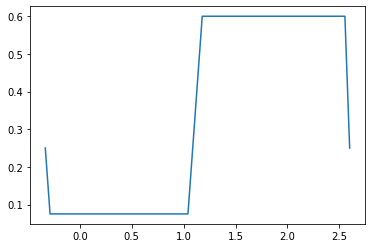

In [30]:
plt.plot(xx, Pg[:, 2], label='After')
plt.show()